In [1]:
import pandas as pd
import numpy as np
import scipy
from pykalman.pykalman import *
import control
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set(style='white', font_scale=1.5)

# Import custom modules
import prep_emotioncon 
import emotioncon_modelling
import emotioncon_stats
import auxiliary

In [2]:
# Create instances of the Modelling and PrepData classes
emo = emotioncon_modelling.Modelling()
prep = prep_emotioncon.PrepEmotioncon()
emostats = emotioncon_stats.Statistics() 

mood_categories = ['disgusted', 'amused', 'calm', 'anxious', 'sad'] # Define the mood categories as a list
filepath = '../' # Specify the file path
debug = True  # Flag to FALSE to save files and figures

# Load data from a numpy file
data = np.load(filepath + 'results/fit_experiment.npy', allow_pickle=True)

# Process the loaded data into a DataFrame, mood ratings, and other related variables
df, mood_ratings, foo = prep.create_df_from_dict(data)

# Create inputs based on videos shown during experiment
inp = emo.input_from_videos('../experiment/public/prep/videosForExperiment.csv')

# Calculate the number of subjects based on the length of the loaded data
Nsj = len(data)
print('N = ' + str(Nsj))

N = 104


In [3]:
# Exclude participants if their estimates show outliers
ex = emostats.exclude_outliers(data, 13, 14, 'results_split')

data = np.delete(data,ex[0])
Nsj = len(data)

Simulate data based on estimated parameters from the most parsimonious model
--

In [4]:
# Get the number of time points from the first subject's ratings data
T = np.shape(data[0]['ratings'])[1]

# Set the number of times to simulated and re-fit data
nruns = 1

# Loop through each subject
for sj in range(Nsj):
    # Create empty arrays to store the simulation results for each subject
    z, x = np.empty((T, 5, nruns)), np.empty((T, 5, nruns))
    
    # Loop through each time point (before and after intervention)
    for t in range(2):
        # Split the input data for the current time point
        inp_split = inp[t*int(T/2):t*int(T/2) + int(T/2), :]
        
        # Loop through each run
        for i in range(nruns):
            # Perform the simulation and store the results in the 'x' array
            foo, x[t*int(T/2):t*int(T/2) + int(T/2), :, i] = \
            data[sj]['results_split'][13+t].sample(int(T/2), initial_state=data[sj]['ratings'][:,t*int(T/2)], \
                                                    control_inputs=inp_split)
        
        # Store the simulation results for the current subject in the 'simulated' field of the data dictionary
        data[sj]['simulated'] = x

if debug == False:
    np.save(filepath + 'results/fit_experiment_recovery.npy', data)

Fit simulated data
--

In [5]:
# Initialize the number of runs
nruns = data[0]['simulated'].shape[2]

# Loop through each subject
for sj in range(Nsj):
    # Create an empty list to store recovery results for each run
    data[sj]['recovery'] = []
    
    # Loop through each run
    for i in range(nruns):
        # Create an empty list to store the Kalman filter results for each time point (before and after intervention)
        results = []
        
        # Extract the data to fit for this run
        data_to_fit = data[sj]['simulated'][:, :, i]
        T = np.shape(data_to_fit)[0]
        
        # Define Kalman filter options
        opt = emo.define_kf_options(data_to_fit, inp)
        opt['em_vars'] = emo.parameter_short(['A', 'C', 'S', 'G'])
        ll_split = 0
        
        # Loop through each time point (before and after intervention)
        for t in range(2):
            # Split the mood ratings and inputs for the current time point
            mood_ratings_split = data_to_fit[t*int(T/2):t*int(T/2) + int(T/2), :]
            inputs_split = inp[t*int(T/2):t*int(T/2) + int(T/2), :]
            
            # Update Kalman filter options with the current inputs
            opt['inp'] = inputs_split 
            
            # Run the Kalman filter
            kf = emo.run_KF(mood_ratings_split, opt)
            results.append(kf)
    
        # Append the results for this run to the subject's recovery list
        data[sj]['recovery'].append(results)

if debug == False:
    np.save(filepath + 'results/fit_experiment_recovery.npy', data)

In [4]:
# Initialize the number of runs
nruns = data[0]['simulated'].shape[2]

# Get the true and estimated transition matrices (A) for each subject and time point
trueA = np.array([data[sj]['results_split'][13+i].transition_matrices \
                  for sj in range(len(data)) for i in range(2)])
estA = np.array([data[sj]['recovery'][r][i].transition_matrices for r in range(nruns)\
                 for sj in range(len(data)) for i in range(2)])

# Get the true and estimated control matrices (C) for each subject and time point
trueC = np.array([data[sj]['results_split'][13+i].control_matrix \
                  for sj in range(len(data)) for i in range(2)])
estC = np.array([data[sj]['recovery'][r][i].control_matrix for r in range(nruns)\
                 for sj in range(len(data)) for i in range(2)])

if nruns > 1: 
    trueA = np.tile(trueA.T, nruns).T
    trueC = np.tile(trueC.T, nruns).T

# Create empty lists to store correlation coefficients
cc, ccc = [], []

# Loop through each time point
for r in range(nruns):
    for i in range(2):
        # Loop through each subject
        for sj in range(len(data)):
            # Calculate the correlation coefficient between the true and estimated transition matrices (A)
            cc.append(scipy.stats.spearmanr(data[sj]['results_split'][13+i].transition_matrices.flatten(), \
                                  data[sj]['recovery'][r][i].transition_matrices.flatten()).correlation)
            # Calculate the correlation coefficient between the true and estimated control matrices (C)
            ccc.append(scipy.stats.spearmanr(data[sj]['results_split'][13+i].control_matrix.flatten(), \
                                  data[sj]['recovery'][r][i].control_matrix.flatten()).correlation)

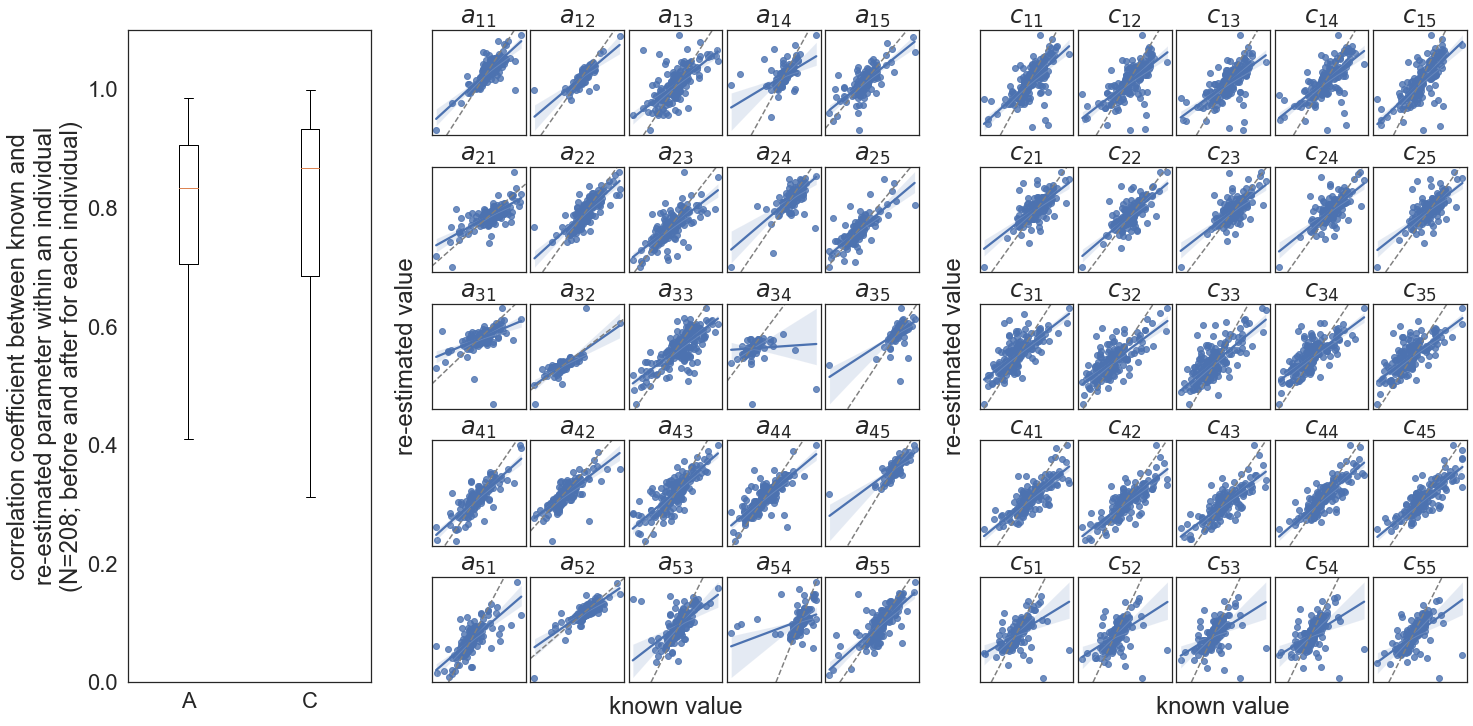

In [5]:
# Increase font size for the plot
sns.set(style='white', font_scale=2)

# Create a figure with 1 row and 3 columns, and adjust the spacing
fig = plt.figure(figsize=(24, 12))
outer = gridspec.GridSpec(1, 3, width_ratios=(1, 2, 2), hspace=0.15, wspace=0.15)

# Create the first subplot for the boxplot
axs = fig.add_subplot(outer[0])
axs.boxplot(np.array([np.abs(cc), np.abs(ccc)]).T, showfliers=False)
axs.set_ylim(0, 1.1)
axs.set_xticks([1, 2], ['A', 'C'])
axs.set_ylabel('correlation coefficient between known and\nre-estimated parameter within an individual\n' + \
         '(N=' + str(len(cc)) + '; before and after for each individual)')

# Loop through each parameter type (A and C)
for p in range(2):

    # Create inner grid for scatter plots
    inner = gridspec.GridSpecFromSubplotSpec(5, 5, subplot_spec=outer[p+1], wspace=0.05, hspace=0.3)

    ax = np.empty((5, 5), dtype=object)
    # Create scatter plots for each pair of parameters
    for i in range(5):
        for j in range(5):
            axs = plt.Subplot(fig, inner[j, i])
            ax[j, i] = fig.add_subplot(axs, sharey=axs, sharex=axs)

    for j in range(5):
        for i in range(5):
            # Plot the scatter plot for the known and re-estimated values of the parameter
            sns.regplot(x=[trueA[:, i, j], trueC[:, i, j]][p], y=[estA[:, i, j], estC[:, i, j]][p], ax=ax[i, j])
            # Add a diagonal dashed line for reference
            ax[i, j].axline((0, 0), slope=1, linestyle='--', color='gray')
            ax[i, j].set_xticklabels([])
            ax[i, j].set_yticklabels([])
            ax[i, j].set_title('$' + ['a', 'c'][p] + '_{' + str(i+1) + str(j+1) + '}$')

    ax[4, 2].set_xlabel('known value')
    ax[2, 0].set_ylabel('re-estimated value')

# Save the figure as an SVG file
plt.savefig('../results/figures/parameter_recovery.svg', bbox_inches='tight')